In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [11]:
df = pd.read_csv("mp_and_njit.csv")
df

,index,n_particles,n_simulations,parallel_time,serial_time
0,0,250,1,1.397848,0.007112
1,0,500,1,1.419504,0.026272
2,0,750,1,1.451497,0.064023
3,0,1000,1,1.462935,0.112348
4,0,1250,1,1.506065,0.217462
...,...,...,...,...,...
1262,0,1750,3,2.930018,1.199063
1263,0,2000,3,3.275994,1.391321
1264,0,250,4,2.590751,0.034797
1265,0,500,4,2.765691,0.127108


In [13]:
grouped = df.groupby(["n_particles","n_simulations"]).agg(["mean","std"])
grouped.head()

index      parallel_time           serial_time  \
                           mean  std          mean       std        mean   
n_particles n_simulations                                                  
250         1               0.0  0.0      1.600036  0.124575    0.007351   
            2               0.0  0.0      1.861216  0.150015    0.016839   
            3               0.0  0.0      2.269998  0.189853    0.025816   
            4               0.0  0.0      2.618193  0.189907    0.035273   
            5               0.0  0.0      3.062141  0.141806    0.046616   

                                     
                                std  
n_particles n_simulations            
250         1              0.000541  
            2              0.001995  
            3              0.002430  
            4              0.003188  
            5              0.005180

Two kinds of plot:
1. n_particles as x and n_simulations as colors
2. n_simulations fixed for each axes, x n_particles

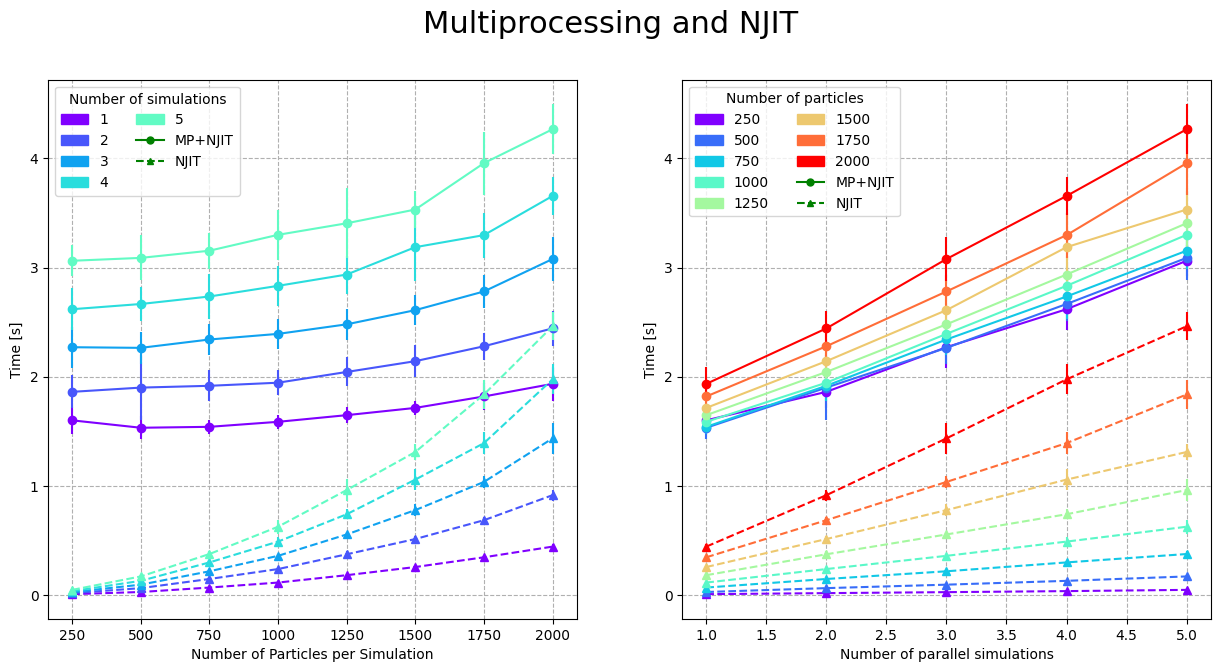

In [122]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.cm as cm


fig, axs = plt.subplots(1, 2, figsize=(15, 7))
colors = [cm.rainbow(i) for i in np.linspace(0, 1, 8)]

legend_handles = []
legend_labels = []
i = 0
for name, group in grouped[["parallel_time", "serial_time"]].groupby("n_simulations"):
    n_particles = group["parallel_time"]["mean"].keys().get_level_values(0).values

    axs[0].errorbar(n_particles, group["parallel_time"].values[:, 0], yerr=group["parallel_time"].values[:, 1], marker="o", label="parallel", c=colors[i])
    axs[0].errorbar(n_particles, group["serial_time"].values[:, 0], yerr=group["serial_time"].values[:, 1], marker="^", label="serial", c=colors[i],linestyle="--")
    # Create custom legend entry with colored patch
    n_simulations_patch = mpatches.Patch(color=colors[i], label=f'{name}')
    legend_handles.append(n_simulations_patch)
    legend_labels.append(f'{name}')

    i += 1

# Add the multiprocessing dot to the legend
multiprocessing_dot = mlines.Line2D([], [], color='green', marker='o', markersize=5, label='Multiprocessing')
njit_dot = mlines.Line2D([], [], color='green', marker='^', markersize=5, linestyle="--", label='NJIT')
legend_handles.append(multiprocessing_dot)
legend_labels.append('MP+NJIT')
legend_handles.append(njit_dot)
legend_labels.append('NJIT')

# Set labels and title
axs[0].set_xlabel('Number of Particles per Simulation')
axs[0].set_ylabel('Time [s]')

# Create custom legend
#axs[0].legend(handles=[parallel_patch, serial_patch], loc="upper left")
#axs[0].set_title("Multiprocessing and NJIT - from 1 to 5 parallel simulations")
axs[0].legend(handles=legend_handles, labels=legend_labels, title="Number of simulations", loc="upper left",ncols=2)
axs[0].grid(linestyle='--')
######################################################

# Store handles and labels for legend creation
legend_handles = []
legend_labels = []
i = 0
for name, group in grouped[["parallel_time", "serial_time"]].groupby("n_particles"):
    n_simulations = group["parallel_time"]["mean"].keys().get_level_values(1).values
    
    # Plot only one point per color for each n_particles
    axs[1].errorbar(n_simulations, group["parallel_time"].values[:, 0], yerr=group["parallel_time"].values[:, 1], marker="o", c=colors[i])
    axs[1].errorbar(n_simulations, group["serial_time"].values[:, 0], yerr=group["serial_time"].values[:, 1], marker="^", c=colors[i], linestyle="--")

    # Create custom legend entry with colored patch
    n_particles_patch = mpatches.Patch(color=colors[i], label=f'{name}')
    legend_handles.append(n_particles_patch)
    legend_labels.append(f'{name}')
    i += 1

# Add the multiprocessing dot to the legend
multiprocessing_dot = mlines.Line2D([], [], color='green', marker='o', markersize=5, label='Multiprocessing')
njit_dot = mlines.Line2D([], [], color='green', marker='^', markersize=5, linestyle="--", label='NJIT')
legend_handles.append(multiprocessing_dot)
legend_labels.append('MP+NJIT')
legend_handles.append(njit_dot)
legend_labels.append('NJIT')

axs[1].legend(handles=legend_handles, labels=legend_labels, title="Number of particles", loc="upper left",ncols=2)

# Set labels and title
axs[1].set_xlabel('Number of parallel simulations')
axs[1].set_ylabel('Time [s]')
axs[1].grid(linestyle='--')

plt.suptitle("Multiprocessing and NJIT",fontsize=22)
plt.savefig("mp_and_njit_with_title.pdf",dpi=300)
plt.show()





## Using parallel numba for loop

In [5]:
df2 = pd.read_csv("FOR_mp_and_njit.csv")
df2

,index,n_particles,n_simulations,parallel_time,serial_time
0,0,250,1,0.908056,0.002136
1,0,500,1,0.906524,0.003009
2,0,750,1,0.950026,0.006809
3,0,1000,1,1.017419,0.008924
4,0,1250,1,0.997051,0.011898
...,...,...,...,...,...
824,0,250,4,1.704114,0.004405
825,0,500,4,1.704558,0.014498
826,0,750,4,1.657246,0.025064
827,0,1000,4,1.809538,0.039563


In [6]:
grouped2 = df2.groupby(["n_particles","n_simulations"]).agg(["mean","std"])
grouped2.head()

index      parallel_time           serial_time  \
                           mean  std          mean       std        mean   
n_particles n_simulations                                                  
250         1               0.0  0.0      0.962169  0.033657    0.002117   
            2               0.0  0.0      1.160892  0.070046    0.003081   
            3               0.0  0.0      1.417110  0.081427    0.003796   
            4               0.0  0.0      1.630654  0.085516    0.004760   
            5               0.0  0.0      1.915243  0.091384    0.005957   

                                     
                                std  
n_particles n_simulations            
250         1              0.000148  
            2              0.000319  
            3              0.000312  
            4              0.000426  
            5              0.000519

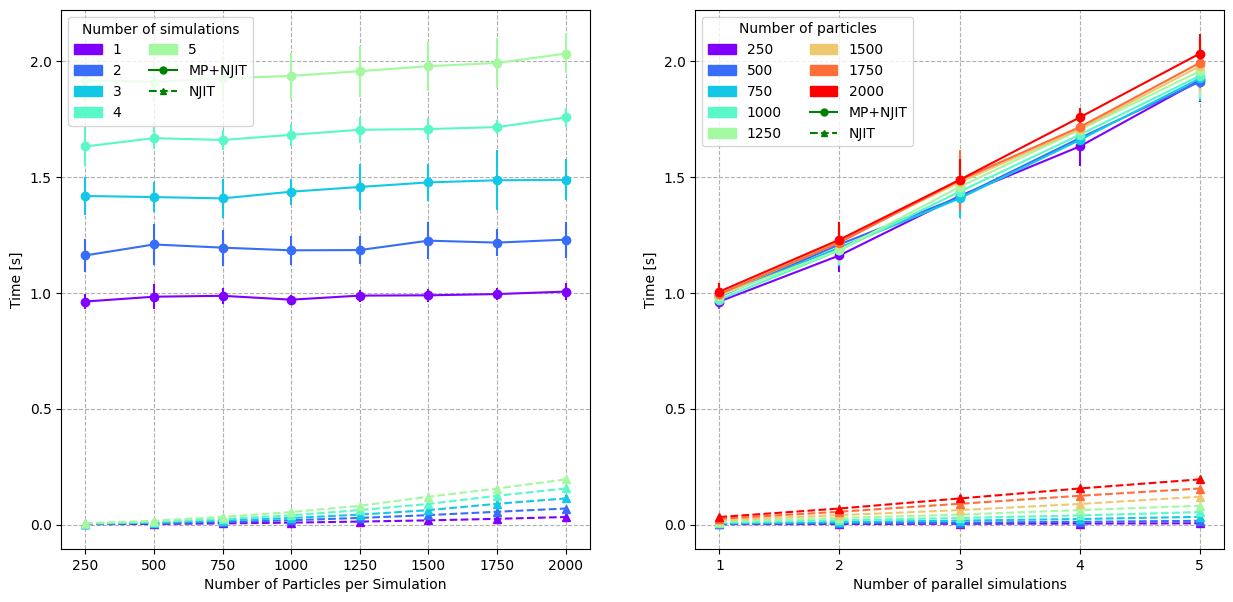

In [10]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.cm as cm


fig, axs = plt.subplots(1, 2, figsize=(15, 7))
colors = [cm.rainbow(i) for i in np.linspace(0, 1, 8)]

legend_handles = []
legend_labels = []
i = 0
for name, group in grouped2[["parallel_time", "serial_time"]].groupby("n_simulations"):
    n_particles = group["parallel_time"]["mean"].keys().get_level_values(0).values

    axs[0].errorbar(n_particles, group["parallel_time"].values[:, 0], yerr=group["parallel_time"].values[:, 1], marker="o", label="parallel", c=colors[i])
    axs[0].errorbar(n_particles, group["serial_time"].values[:, 0], yerr=group["serial_time"].values[:, 1], marker="^", label="serial", c=colors[i],linestyle="--")
    # Create custom legend entry with colored patch
    n_simulations_patch = mpatches.Patch(color=colors[i], label=f'{name}')
    legend_handles.append(n_simulations_patch)
    legend_labels.append(f'{name}')

    i += 1

# Add the multiprocessing dot to the legend
multiprocessing_dot = mlines.Line2D([], [], color='green', marker='o', markersize=5, label='Multiprocessing')
njit_dot = mlines.Line2D([], [], color='green', marker='^', markersize=5, linestyle="--", label='NJIT')
legend_handles.append(multiprocessing_dot)
legend_labels.append('MP+NJIT')
legend_handles.append(njit_dot)
legend_labels.append('NJIT')

# Set labels and title
axs[0].set_xlabel('Number of Particles per Simulation')
axs[0].set_ylabel('Time [s]')

# Create custom legend
#axs[0].legend(handles=[parallel_patch, serial_patch], loc="upper left")
#axs[0].set_title("Multiprocessing and NJIT - from 1 to 5 parallel simulations")
axs[0].legend(handles=legend_handles, labels=legend_labels, title="Number of simulations", loc="upper left",ncols=2)
axs[0].grid(linestyle='--')
######################################################

# Store handles and labels for legend creation
legend_handles = []
legend_labels = []
i = 0
for name, group in grouped2[["parallel_time", "serial_time"]].groupby("n_particles"):
    n_simulations = group["parallel_time"]["mean"].keys().get_level_values(1).values
    
    # Plot only one point per color for each n_particles
    axs[1].errorbar(n_simulations, group["parallel_time"].values[:, 0], yerr=group["parallel_time"].values[:, 1], marker="o", c=colors[i])
    axs[1].errorbar(n_simulations, group["serial_time"].values[:, 0], yerr=group["serial_time"].values[:, 1], marker="^", c=colors[i], linestyle="--")

    # Create custom legend entry with colored patch
    n_particles_patch = mpatches.Patch(color=colors[i], label=f'{name}')
    legend_handles.append(n_particles_patch)
    legend_labels.append(f'{name}')
    i += 1

# Add the multiprocessing dot to the legend
multiprocessing_dot = mlines.Line2D([], [], color='green', marker='o', markersize=5, label='Multiprocessing')
njit_dot = mlines.Line2D([], [], color='green', marker='^', markersize=5, linestyle="--", label='NJIT')
legend_handles.append(multiprocessing_dot)
legend_labels.append('MP+NJIT')
legend_handles.append(njit_dot)
legend_labels.append('NJIT')

axs[1].legend(handles=legend_handles, labels=legend_labels, title="Number of particles", loc="upper left",ncols=2)

# Set labels and title
axs[1].set_xlabel('Number of parallel simulations')
axs[1].set_ylabel('Time [s]')
axs[1].grid(linestyle='--')
axs[1].set_xticks([1,2,3,4,5])
#plt.suptitle("Multiprocessing and NJIT",fontsize=22)
plt.savefig("for_numba_parallel_mp_and_njit.pdf",dpi=300)
plt.show()



